# Machine Learning in Crowd Modelling and Simulation
# Final Project
# Task 5: EDMD on Crowd Dynamics

### Group M:
1. Muhammad Waleed Bin Khalid
2. Qais Hamarneh
3. Yiming Zhang

# Useful Imports

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from EDMD import EDMD
from tqdm import tqdm
from io import StringIO
from datafold.appfold import EDMD as datafold_EDMD
from datafold.dynfold.transform import TSCPolynomialFeatures
from datafold.pcfold import TSCDataFrame

from Observables import *
from utils import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# The Trajectory Dataset

In [14]:
with open('data/postvis.traj') as f:
    lines = f.read()
ped_traj_df = pd.read_csv(StringIO(lines), sep=' ')
ped_traj_df

,pedestrianId,simTime,endTime-PID1,startX-PID1,startY-PID1,endX-PID1,endY-PID1,targetId-PID2
0,1,0.400000,0.957365,5.890973,4.204623,6.312940,4.166664,4
1,2,0.400000,1.033053,8.607234,7.263299,9.384863,7.601927,4
2,3,0.400000,1.117193,1.973335,2.212365,2.630341,2.376340,4
3,4,0.400000,1.178352,7.635275,3.410553,7.958087,3.439929,4
4,5,0.400000,1.033995,6.186206,3.221315,6.669568,2.889827,4
...,...,...,...,...,...,...,...,...
5144,74,54.851343,55.587172,26.442616,5.142354,27.111536,5.142354,4
5145,43,55.033973,55.814458,24.584583,5.258363,25.211121,5.258363,4
5146,43,55.814458,56.594944,25.211121,5.258363,25.837659,5.258363,4
5147,43,56.594944,57.375429,25.837659,5.258363,26.464197,5.258363,4


In [9]:
print(f"Delta t for pedestrian 1 is {np.diff(ped_traj_df[ped_traj_df.pedestrianId == 1].simTime.to_numpy())[0]:0.4f}")
print(f"Delta t for pedestrian 2 is {np.diff(ped_traj_df[ped_traj_df.pedestrianId == 2].simTime.to_numpy())[1]:0.4f}")

Delta t for pedestrian 1 is 0.5574
Delta t for pedestrian 2 is 0.6331


In [45]:
# len(np.diff(ped_traj_df[ped_traj_df.pedestrianId == 1].simTime.to_numpy()))
# ped_traj_df.pedestrianId.unique()
ped_traj_df[ped_traj_df.pedestrianId == 1]

,pedestrianId,simTime,endTime-PID1,startX-PID1,startY-PID1,endX-PID1,endY-PID1,targetId-PID2
0,1,0.400000,0.957365,5.890973,4.204623,6.312940,4.166664,4
132,1,0.957365,1.514730,6.312940,4.166664,6.462486,4.266361,4
232,1,1.514730,2.072095,6.462486,4.266361,6.761686,4.326681,4
331,1,2.072095,2.629460,6.761686,4.326681,7.226400,4.403866,4
429,1,2.629460,3.186824,7.226400,4.403866,7.699841,4.334903,4
521,1,3.186824,3.744189,7.699841,4.334903,8.096677,4.483288,4
614,1,3.744189,4.301554,8.096677,4.483288,8.770573,4.690393,4
708,1,4.301554,4.858919,8.770573,4.690393,9.515627,4.796014,4
804,1,4.858919,5.416284,9.515627,4.796014,10.236961,4.946513,4
897,1,5.416284,5.973649,10.236961,4.946513,10.943098,5.257549,4


## Resampling Pedestrian Steps

In [64]:
pd.options.mode.chained_assignment = None  # default='warn'

delta_t = 0.4
resampled_trajectory_list = []
for ped in tqdm(list(ped_traj_df.pedestrianId.unique())):
    df = ped_traj_df[ped_traj_df.pedestrianId == ped]
    ped_time_delta = np.diff(df.simTime.to_numpy())[0]
    if ped_time_delta < delta_t:
        print("Pedestrian delta should be larger for proper resampling!")
        break
    else:
        resampled_df = df.copy(deep=True)
        # Linear interpolation
        simTime = np.cumsum(delta_t * np.ones((len(df.simTime), 1)))
        resampled_df.simTime = simTime
        resampled_df['startX-PID1'].iloc[1:] = df['startX-PID1'].iloc[:-1] + np.diff(df['startX-PID1'].to_numpy()) * delta_t / ped_time_delta
        resampled_df['startY-PID1'].iloc[1:] = df['startY-PID1'].iloc[:-1] + np.diff(df['startY-PID1'].to_numpy()) * delta_t / ped_time_delta
        resampled_df['endX-PID1'].iloc[1:] = df['endX-PID1'].iloc[:-1] + np.diff(df['endX-PID1'].to_numpy()) * delta_t / ped_time_delta
        resampled_df['endY-PID1'].iloc[1:] = df['endY-PID1'].iloc[:-1] + np.diff(df['endY-PID1'].to_numpy()) * delta_t / ped_time_delta
        resampled_trajectory_list.append(resampled_df)
#         break
resampled_pred_traj = pd.concat(resampled_trajectory_list)

resampled_pred_traj


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 77.52it/s]


,pedestrianId,simTime,endTime-PID1,startX-PID1,startY-PID1,endX-PID1,endY-PID1,targetId-PID2
0,1,0.4,0.957365,5.890973,4.204623,6.312940,4.166664,4
132,1,0.8,1.514730,6.193803,4.177381,6.420263,4.238213,4
232,1,1.2,2.072095,6.420263,4.238213,6.677211,4.309651,4
331,1,1.6,2.629460,6.677211,4.309651,7.095194,4.382074,4
429,1,2.0,3.186824,7.095194,4.382074,7.566171,4.354374,4
...,...,...,...,...,...,...,...,...
5059,100,26.0,47.171955,23.531779,4.471115,24.196339,4.471115,4
5070,100,26.4,47.891524,24.196339,4.471115,24.860900,4.471115,4
5080,100,26.8,48.611092,24.860900,4.471115,25.525460,4.471115,4
5091,100,27.2,49.330661,25.525460,4.471115,26.190021,4.471115,4


## Formatting Pedestrian Data

In [65]:
ped_traj_df_formatted = format_traj_df(resampled_pred_traj)
ped_traj_df_formatted

,ID,x1,x2,y1,y2
0,1,5.890973,4.204623,6.312940,4.166664
132,1,6.193803,4.177381,6.420263,4.238213
232,1,6.420263,4.238213,6.677211,4.309651
331,1,6.677211,4.309651,7.095194,4.382074
429,1,7.095194,4.382074,7.566171,4.354374
...,...,...,...,...,...
5059,100,23.531779,4.471115,24.196339,4.471115
5070,100,24.196339,4.471115,24.860900,4.471115
5080,100,24.860900,4.471115,25.525460,4.471115
5091,100,25.525460,4.471115,26.190021,4.471115


# Actual Pedestrian Trajectories

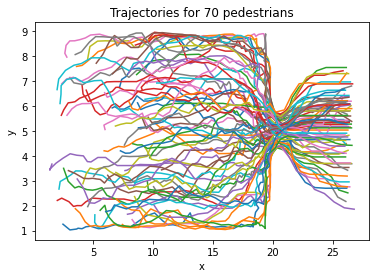

In [66]:
def plot_trajectories(traj_df: pd.DataFrame, no_peds: int, ax):
    for ped in range(no_peds+1):
        df = traj_df[traj_df.ID == ped]
        ax.plot(df.x1.to_numpy(), df.x2.to_numpy())
    ax.set_xlabel('x'), ax.set_ylabel('y'), ax.set_title(f"Trajectories for {no_peds} pedestrians")


fig, ax = plt.subplots()
plot_trajectories(ped_traj_df_formatted, 70, ax)

# Equal Data

Since we need equal data for each pedestrian, pedestrians that reach the target early have the same position appended until their data count is same as the latest pedestrian. The assumption here is that pedestrians simply stop on reaching the target.

In [67]:
ped_traj_df_formatted.groupby('ID').count().head()

,x1,x2,y1,y2
ID,,,,
1,47,47,47,47
2,36,36,36,36
3,63,63,63,63
4,54,54,54,54
5,43,43,43,43


In [68]:
# def append_end_loc_to_ped_traj(traj_df_formatted: pd.DataFrame):
#     max_steps = traj_df_formatted.groupby('ID').count().iloc[:,1].max()
#     for ped in list(traj_df_formatted.ID.unique()):
#         df = traj_df_formatted[traj_df_formatted.ID == ped]
#         curr_steps = len(df)
#         if curr_steps < max_steps:
#             last_loc = df.iloc[-1,:].to_numpy()
#             df_to_append = pd.DataFrame(np.tile(last_loc, (max_steps - curr_steps, 1)), columns=list(traj_df_formatted.columns))
#             traj_df_formatted = traj_df_formatted.append(df_to_append)
#     traj_df_formatted.reset_index(drop=True, inplace=True)
#     return traj_df_formatted

# def remove_end_loc_to_ped_traj(traj_df: pd.DataFrame):
#     min_steps = traj_df.groupby('ID').count().iloc[:,1].min()
#     traj_df_formatted = pd.DataFrame()
#     for ped in list(traj_df.ID.unique()):
#         df = traj_df[traj_df.ID == ped]
#         curr_steps = len(df)
#         if curr_steps > min_steps:
#             df.reset_index(drop=True, inplace=True)
#             df = df.drop(range(min_steps, len(df)))
#             traj_df_formatted = traj_df_formatted.append(df)
#     traj_df_formatted.reset_index(drop=True, inplace=True)
#     return traj_df_formatted

# ped_traj_df_formatted_reduced = remove_end_loc_to_ped_traj(ped_traj_df_formatted)
# ped_traj_df_formatted_reduced = append_end_loc_to_ped_traj(ped_traj_df_formatted)
ped_traj_df_formatted_reduced = ped_traj_df_formatted
# ped_traj_df_formatted_reduced.groupby('ID').count().head()

# Finding Center of Gravity from Actual Data

In [81]:
center_of_gravity = find_center_of_gravity(ped_traj_df_formatted_reduced)

100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [00:10<00:00,  9.66it/s]


(Text(0.5, 0, 'x'), Text(0, 0.5, 'y'), Text(0.5, 1.0, 'Center of Gravity'))

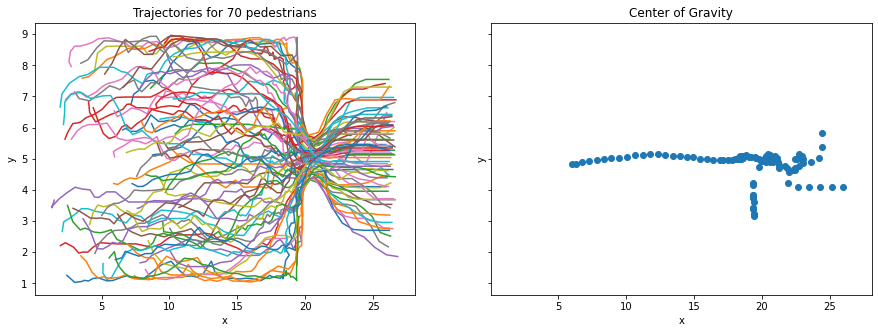

In [82]:
fig, axs = plt.subplots(1, 2, figsize=(15,5), sharex=True, sharey=True)
plot_trajectories(ped_traj_df_formatted_reduced, 70, axs[0])
axs[1].scatter(center_of_gravity[:,0], center_of_gravity[:,1])
axs[1].set_xlabel('x'), axs[1].set_ylabel('y'), axs[1].set_title("Center of Gravity")

# Applying EDMD with Polynomial Dictionary of Observables

In [83]:
polynomial_observables = Polynomials(5)
# polynomial_observables.fit(ped_traj_df_formatted_reduced.iloc[:,0:3])
polynomial_observables.segregate_observables_from_variable(polynomial_observables.fit(ped_traj_df_formatted_reduced.iloc[:,0:3]))

,ID,x1^0x2^1,x1^0x2^2,x1^0x2^3,x1^0x2^4,x1^0x2^5,x1^1x2^0,x1^1x2^1,x1^1x2^2,x1^1x2^3,...,x1^2x2^0,x1^2x2^1,x1^2x2^2,x1^2x2^3,x1^3x2^0,x1^3x2^1,x1^3x2^2,x1^4x2^0,x1^4x2^1,x1^5x2^0
0,1,4.204623,17.678859,74.332944,312.542042,1314.121608,5.890973,24.769322,104.145674,437.893347,...,34.703560,145.915403,613.519329,2579.617776,204.437726,859.583661,3614.225646,1204.337070,5.063784e+03,7.094717e+03
132,1,4.177381,17.450516,72.897460,304.520494,1272.098256,6.193803,25.873877,108.085052,451.512487,...,38.363193,160.257689,669.457492,2796.579292,237.614049,992.604515,4146.487663,1471.734553,6.147997e+03,9.115634e+03
232,1,4.238213,17.962450,76.128692,322.649621,1367.457851,6.420263,27.210444,115.323661,488.766252,...,41.219781,174.698218,740.408276,3138.008056,264.641852,1121.608565,4753.616116,1699.070383,7.201022e+03,1.090848e+04
331,1,4.309651,18.573088,80.043517,344.959583,1486.655247,6.677211,28.776444,124.016418,534.467421,...,44.585142,192.146380,828.083745,3568.751544,297.704383,1283.001850,5529.289590,1987.834873,8.566874e+03,1.327319e+04
429,1,4.382074,19.202574,84.147101,368.738834,1615.840901,7.095194,31.091666,136.245985,597.040007,...,50.341778,220.601403,966.691701,4236.114689,357.184683,1565.209758,6858.865177,2534.294628,1.110547e+04,1.798131e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5059,100,4.471115,19.990873,89.381499,399.634998,1786.814191,23.531779,105.213300,470.420803,2103.305695,...,553.744625,2475.856118,11069.838404,49494.524896,13030.596174,58261.299142,260492.991459,306633.110059,1.370992e+06,7.215623e+06
5070,100,4.471115,19.990873,89.381499,399.634998,1786.814191,24.196339,108.184626,483.705947,2162.705104,...,585.462845,2617.671937,11703.913295,52329.546901,14166.057748,63338.078866,283191.859433,342766.742486,1.532550e+06,8.293700e+06
5080,100,4.471115,19.990873,89.381499,399.634998,1786.814191,24.860900,111.155952,496.991090,2222.104512,...,618.064345,2763.437008,12355.645747,55243.517899,15365.635834,68701.530912,307172.472442,382003.534778,1.707982e+06,9.496952e+06
5091,100,4.471115,19.990873,89.381499,399.634998,1786.814191,25.525460,114.127279,510.276233,2281.503920,...,651.549127,2913.151331,13025.035760,58236.437891,16631.091413,74359.528832,332470.034038,424516.264681,1.898061e+06,1.083597e+07


In [87]:
edmd = EDMD(ped_traj_df_formatted_reduced, 2, polynomial_observables)
edmd.fit()

In [92]:
initial_values = ped_traj_df_formatted.groupby('ID').first().iloc[:,:2]
initial_values.insert(0,'ID',initial_values.index)
initial_values
traj_pred = edmd.predict(initial_values, t_end=105)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [08:17<00:00,  4.97s/it]


In [99]:
def remove_extrapolated_data(pred_data, org_data):
    pred_df_list = []
    for id in tqdm(org_data.ID.unique()):
        df_org = org_data[org_data.ID == id]
        df_pred = pred_data[pred_data.ID == id].iloc[:len(df_org)]
        pred_df_list.append(df_pred)
    return pd.concat(pred_df_list)
        
        
traj_pred_formatted = remove_extrapolated_data(traj_pred, ped_traj_df_formatted_reduced)

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 319.54it/s]


In [123]:
len(traj_pred_formatted[traj_pred_formatted.ID == 2])
# traj_pred[traj_pred.ID == 2]
len(ped_traj_df_formatted[ped_traj_df_formatted.ID == 2])
# traj_pred_formatted.groupby('ID').count()

36

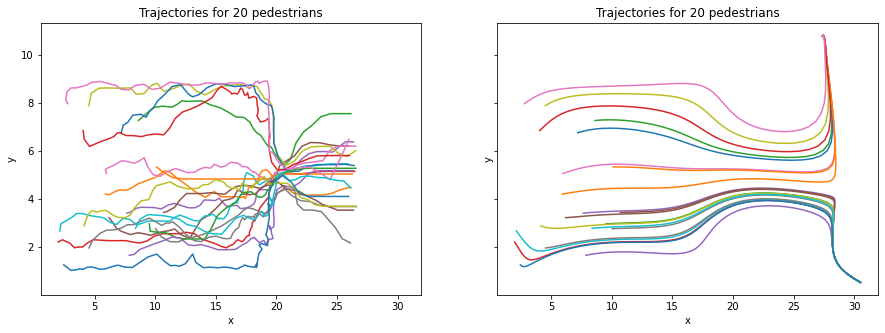

In [126]:
fig, axs = plt.subplots(1, 2, figsize=(15,5), sharex=True, sharey=True)
no_peds = 20
plot_trajectories(ped_traj_df_formatted, no_peds, axs[0])
# plot_trajectories(traj_pred_formatted, no_peds, axs[1])
plot_trajectories(traj_pred, no_peds, axs[1])

100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [00:08<00:00, 11.73it/s]


MSE of center of gravity is 28.88005


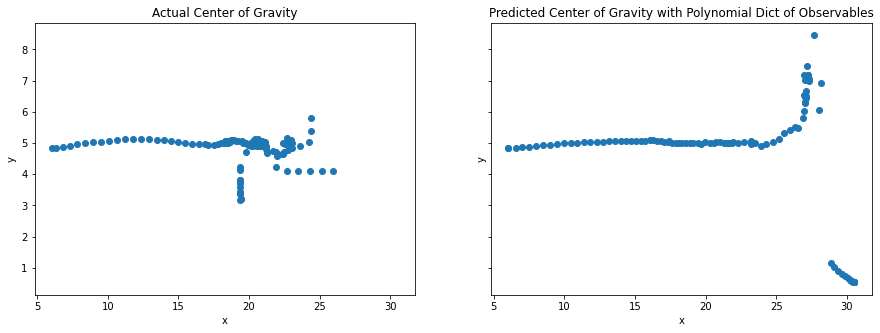

In [106]:
# center_of_gravity = find_center_of_gravity(ped_traj_df_formatted)
center_of_gravity_edmd = find_center_of_gravity(traj_pred_formatted)
fig, axs = plt.subplots(1, 2, figsize=(15,5), sharex=True, sharey=True)
axs[0].scatter(center_of_gravity[:,0], center_of_gravity[:,1])
axs[0].set_xlabel('x'), axs[0].set_ylabel('y'), axs[0].set_title("Actual Center of Gravity")
axs[1].scatter(center_of_gravity_edmd[:,0], center_of_gravity_edmd[:,1])
axs[1].set_xlabel('x'), axs[1].set_ylabel('y'), axs[1].set_title("Predicted Center of Gravity with Polynomial Dict of Observables")
print(f"MSE of center of gravity is {np.sum((center_of_gravity - center_of_gravity_edmd[:center_of_gravity.shape[0],:])**2) / center_of_gravity_edmd.shape[0]:0.5f}")

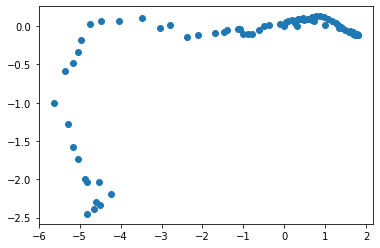

In [125]:
temp = center_of_gravity - center_of_gravity_edmd
plt.scatter(temp[:-30,0], temp[:-30,1])

# Applying EDMD with Identity Dictionary of Observables

In [34]:
identity_observables = Identity()
identity_observables.fit(ped_traj_df_formatted_reduced.iloc[:,0:3])
edmd_identity = EDMD(ped_traj_df_formatted_reduced, 2, identity_observables)
edmd_identity.fit()
traj_pred_identity = edmd_identity.predict(initial_values, t_end=20)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.02it/s]


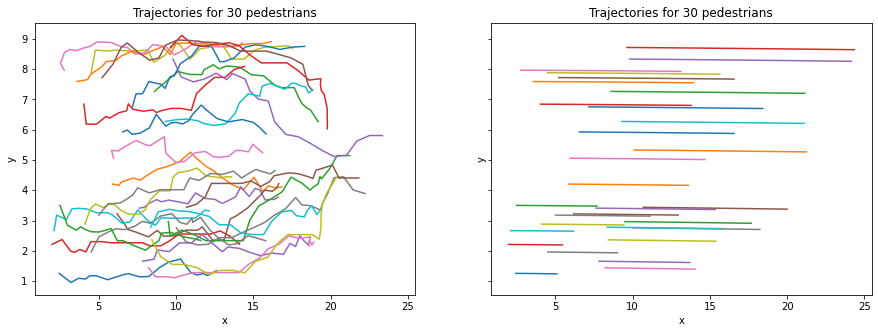

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(15,5), sharex=True, sharey=True)
no_peds = 30
plot_trajectories(ped_traj_df_formatted_reduced, no_peds, axs[0])
plot_trajectories(traj_pred_identity, no_peds, axs[1])

100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 21.31it/s]


MSE of center of gravity is 3.82248


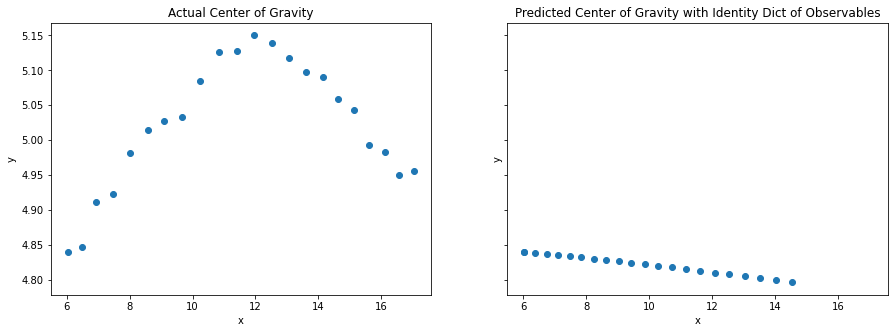

In [36]:
center_of_gravity_edmd_identity = find_center_of_gravity(traj_pred_identity)
fig, axs = plt.subplots(1, 2, figsize=(15,5), sharex=True, sharey=True)
axs[0].scatter(center_of_gravity[:,0], center_of_gravity[:,1])
axs[0].set_xlabel('x'), axs[0].set_ylabel('y'), axs[0].set_title("Actual Center of Gravity")
axs[1].scatter(center_of_gravity_edmd_identity[:,0], center_of_gravity_edmd_identity[:,1])
axs[1].set_xlabel('x'), axs[1].set_ylabel('y'), axs[1].set_title("Predicted Center of Gravity with Identity Dict of Observables")
print(f"MSE of center of gravity is {np.sum((center_of_gravity - center_of_gravity_edmd_identity[:center_of_gravity.shape[0],:])**2) / center_of_gravity_edmd_identity.shape[0]:0.5f}")

# Datafold

In [3]:
with open('data/postvis.traj') as f:
    lines = f.read()
ped_traj_df = pd.read_csv(StringIO(lines), sep=' ')
ped_traj_df

,pedestrianId,simTime,endTime-PID1,startX-PID1,startY-PID1,endX-PID1,endY-PID1,targetId-PID2
0,1,0.400000,0.957365,5.890973,4.204623,6.312940,4.166664,4
1,2,0.400000,1.033053,8.607234,7.263299,9.384863,7.601927,4
2,3,0.400000,1.117193,1.973335,2.212365,2.630341,2.376340,4
3,4,0.400000,1.178352,7.635275,3.410553,7.958087,3.439929,4
4,5,0.400000,1.033995,6.186206,3.221315,6.669568,2.889827,4
...,...,...,...,...,...,...,...,...
5144,74,54.851343,55.587172,26.442616,5.142354,27.111536,5.142354,4
5145,43,55.033973,55.814458,24.584583,5.258363,25.211121,5.258363,4
5146,43,55.814458,56.594944,25.211121,5.258363,25.837659,5.258363,4
5147,43,56.594944,57.375429,25.837659,5.258363,26.464197,5.258363,4


In [25]:
df_list = []
for id in list(ped_traj_df.pedestrianId.unique()):
    df = ped_traj_df[ped_traj_df.pedestrianId == id].iloc[:,:5]
#     df = df.set_index('simTime')
    df.reset_index(drop=True, inplace=True)
    df.drop('simTime', axis=1, inplace=True)
    df.drop('endTime-PID1', axis=1, inplace=True)
    df.drop('pedestrianId', axis=1, inplace=True)
    df_list.append(df)
    
df_list[1]
a = TSCDataFrame.from_frame_list(df_list)
a

feature  startX-PID1  startY-PID1
ID time                          
0  0        5.890973     4.204623
   1        6.312940     4.166664
   2        6.462486     4.266361
   3        6.761686     4.326681
   4        7.226400     4.403866
...              ...          ...
99 64      23.826918     4.471115
   65      24.491478     4.471115
   66      25.156039     4.471115
   67      25.820599     4.471115
   68      26.485160     4.471115

[5149 rows x 2 columns]